# Gill_HW3

This homework assignment presents a simple data model for airport simulation using DES. Flyers who have an outgoing flight will go through the departure process at DTW airport before boarding their respective flights. 

NOTE: Flyer arrivals in this assignment is NOT referring to passengers arriving from another airport to DTW and then leaving the airport. Rather, passengers show up at airport and are expected to go through the process of checking-in with airline, adding any checked-bags, going through a TSA security check, finding their respective gate, and boarding the flight

## Preliminaries

In [45]:
# To auto-reload modules in jupyter notebook (so that changes in files *.py doesn't require manual reloading):
# https://stackoverflow.com/questions/5364050/reloading-submodules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Import commonly used libraries and magic command for inline plotting

In [46]:
import math
import numpy as np
import pandas as pd
from scipy import optimize
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.random import default_rng
from IPython.display import Image
import simpy

In [47]:
%matplotlib inline

## SimPy Model 1: Create a flyer departure generator

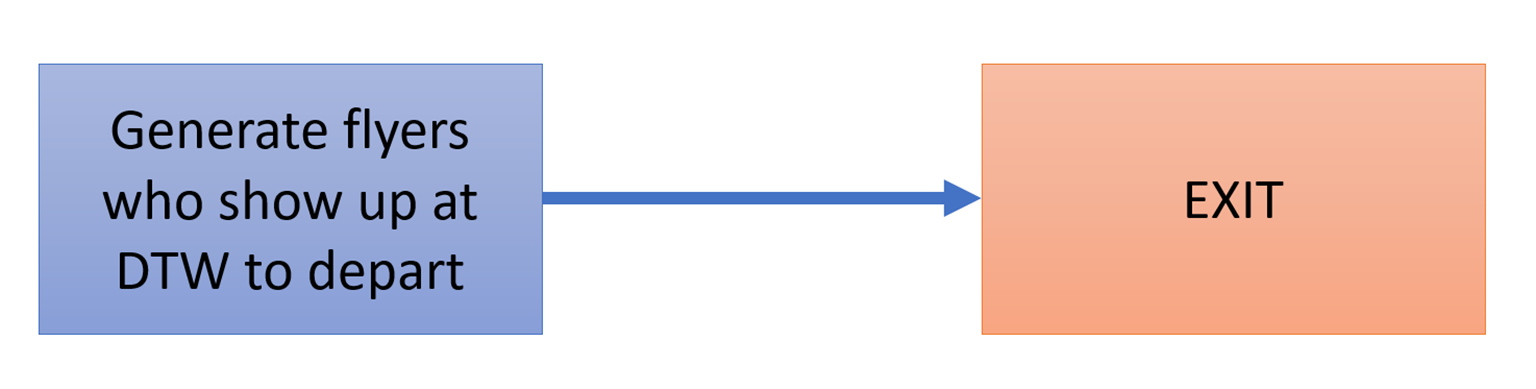

In my function, I take in two parameters: the simulation environment(env) and the interarrival_time which will have flyers show up every minute with a default of 5.0

In [48]:
def flyer_arrivals(env, interarrival_time=5.0):
    """Gnereate flyers according to a fixed time arrival process"""
    
    # Make a counter to keep track of flyers entering airport (uniqueID)
    flyer = 0
    
    # We want to keep generating flyers, so an infinite* loop is used
    while True:
        # Create next interarrival time
        next_time = interarrival_time
        
        # Yield a timeout event and resume after next_time units
        yield env.timeout(next_time)
        
        # Every time a new flyer enters the airport, we want to update our flyer variable
        flyer += 1
        
        print(f"Flyer {flyer} created at time {env.now}")

Create a simple simulation model that generates flyers for a fixed interval of time.

In [49]:
# Initialize a new environment
env1 = simpy.Environment()

# Create generator and add flyer to environment for equally-spaced interarrival_time values
runtime = 33
interarrival_time = 3.0
flyer_generator = flyer_arrivals(env1, interarrival_time)
env1.process(flyer_generator)

# Run simulation
env1.run(until=runtime)

Flyer 1 created at time 3.0
Flyer 2 created at time 6.0
Flyer 3 created at time 9.0
Flyer 4 created at time 12.0
Flyer 5 created at time 15.0
Flyer 6 created at time 18.0
Flyer 7 created at time 21.0
Flyer 8 created at time 24.0
Flyer 9 created at time 27.0
Flyer 10 created at time 30.0


 Since not everyone who shows up at an airport arrives in equally-spaced time intervals. Thus, we will use a Poisson arrival process to generate random intervals. 

In [50]:
from numpy.random import default_rng
rg = default_rng(seed=2468)
print(rg.random())
print(rg.random())

0.4152638067771849
0.6286949390827768


Create a histogram the visually present the times of arrivals at DTW by flyers wanting to depart.

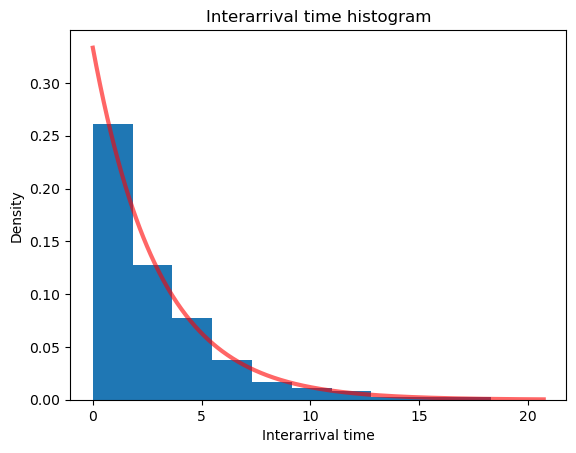

In [51]:
from scipy.stats import expon
# Set mean of distrubution to interarrival_time
mean_interarrival_time = interarrival_time

# Make a random variable object based on distribution above
rv_expon = expon(scale=mean_interarrival_time)

# Create 1000 exponential random variates using numpy
time_sample = rg.exponential(mean_interarrival_time, 1000)

# Make a histogram of the sample
plt.title("Interarrival time histogram")
plt.xlabel("Interarrival time")
plt.ylabel("Density")
plt.hist(time_sample, density=True);

# Make values for x-axis
x_expon = np.linspace(rv_expon.ppf(0.0001),
                      rv_expon.ppf(0.999), 500)

# Create values for y-axis
y_expon_pdf = rv_expon.pdf(x_expon)

plt.plot(x_expon, y_expon_pdf, 'r-', lw=3, alpha=0.6, label='Exponential PDF');

Modify our flyer arrivals function to use Posson arrivals.

In [52]:
def flyer_arrivals_random_1(env, mean_interarrival_time=5.0, rg=default_rng(0)):
    """Create flyers entering DTW under a Posson arrival process"""
    
    # Create a counter to keep track of number of flyers generated (uniqueID)
    flyer = 0 
    
    # As before, we will create an infinite* loop 
    while True:
        # Create next interarrival time from exponential distribution
        next_time = rg.exponential(mean_interarrival_time)
        
        # Yield a timeout event and resume after next_time units
        yield env.timeout(next_time)
        
        # Every time a new flyer enters the airport, we want to update our flyer variable
        flyer += 1
        
        print(f"Flyer {flyer} created at time {env.now}")

Create a new simulation environment and run the new arrival model, so that arrivals are not equally spaced.

In [53]:
# Initialize a simulation environment
env2 = simpy.Environment()

# Create a process generator and add it to the 'env', and use env.process()
runtime = 35
interarrival_time = 3.0
env2.process(flyer_arrivals_random_1(env2, interarrival_time))

# Run the simulation
env2.run(until=runtime)

Flyer 1 created at time 2.039795711906729
Flyer 2 created at time 5.098587016304323
Flyer 3 created at time 5.158007004071489
Flyer 4 created at time 5.164814984115174
Flyer 5 created at time 6.815843602032318
Flyer 6 created at time 11.705664906007474
Flyer 7 created at time 13.72641376400917
Flyer 8 created at time 15.992317837485343
Flyer 9 created at time 24.44267577471252


## SimPy Model 2: Airport simulation with delay processes